<a href="https://colab.research.google.com/github/JohannesKarwou/notebooks/blob/main/freeSolvSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install sketch

In [11]:
import sketch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/finalOverview.csv")

In [6]:
def plotting_grey_area(i):
    # shaded grey area   
    x = np.linspace(-30,20,5)
    y = x
    axs[i].plot(x, y, alpha = 0.9, color = 'C7',linestyle='dashed')
    y2 = x +1
    axs[i].plot(x, y2, alpha = 0.3, color = 'C7',linestyle='dashed')
    y3 = x -1 
    axs[i].plot(x, y3, alpha = 0.3, color = 'C7',linestyle='dashed')
    axs[i].fill_between(x,y2,y3, alpha = 0.3, color = 'Grey')

    x = np.linspace(-30,20,5)
    y = x
    axs[i].plot(x, y, alpha = 0.9, color = 'C7',linestyle='dashed')
    y2 = x +2
    axs[i].plot(x, y2, alpha = 0.3, color = 'C7',linestyle='dashed')
    y3 = x -2 
    axs[i].plot(x, y3, alpha = 0.3, color = 'C7',linestyle='dashed')
    axs[i].fill_between(x,y2,y3, alpha = 0.3, color = 'Grey')

In [7]:
def bootstrap_function(x_values, y_values):
  # bootstrap metric
  def bootstrap_metric(fct, x_values, y_values):
      assert callable(fct) == True
      bootstrapped_metric = []
      # bootstrap metric to generate test distribution
      for _ in range(1000):
          indices = np.random.choice(range(0, len(x_values)), size=len(x_values), replace=True)
          x_selection = np.take(x_values, indices)
          y_selection = np.take(y_values, indices)
          r = fct(x_selection, y_selection)
          bootstrapped_metric.append(r)    

      # define 90% CI
      alpha = 10.0
      lower_p = alpha / 2.0
      # get value at or near percentile (take a look at the definition of percentile if 
      # you have less than 100 values to make sure you understand what is happening)
      lower = np.percentile(bootstrapped_metric, lower_p)
      upper_p = (100 - alpha) + (alpha / 2.0)
      upper = np.percentile(bootstrapped_metric, upper_p)
      # calculate true mean
      mean = fct(x_values, y_values)

      return mean, lower, upper

  # bootstrap MAE
  mean, lower, upper = bootstrap_metric(mean_absolute_error, x_values, y_values)
  print(f'MAE:  {round(mean, 2):.2f} [{round(lower,2):.2f}, {round(upper,2):.2f}]')

  # bootstrap RMSE
  def calc_rmse(x_values, y_values):
      return np.sqrt(mean_squared_error(x_values, y_values))
  mean, lower, upper = bootstrap_metric(calc_rmse, x_values, y_values)
  print(f'RMSE:  {round(mean, 2):.2f} [{round(lower,2):.2f}, {round(upper,2):.2f}]')

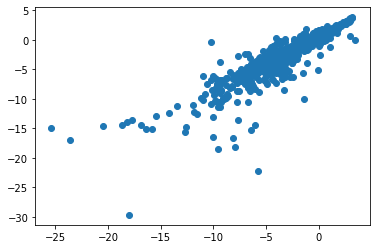

In [13]:
plt.scatter(data[" experimental value (kcal/mol)"],data["dG (TF)"])

In [33]:
data = data[~np.isnan(data['dG (TF)'])]

bootstrap_function(data[" experimental value (kcal/mol)"],data["dG (TF)"])

MAE:  1.37 [1.27, 1.48]
RMSE:  2.07 [1.84, 2.34]


In [16]:
data["dG (TF)"]

0      -4.75
1      -5.40
2      -4.48
3      -3.01
4     -10.32
       ...  
637     0.54
638    -5.60
639    -1.62
640     2.68
641    -3.82
Name: dG (TF), Length: 642, dtype: float64

In [30]:
%env SKETCH_MAX_COLUMNS 22
data.sketch.howto("Remove nan or infinity from dG (TF) colum")

env: SKETCH_MAX_COLUMNS=22
